# Import Libraries

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

if device == 'cuda': print(torch.cuda.get_device_name())

cuda


# Physics Informed Neural Network

In [13]:
class PINN(nn.Module):
    """
    Physics-Informed Neural Network (PINN) for solving the Helmholtz equation.

    Attributes
    ----------
    layers : nn.ModuleList
        List of neural network layers.
    ub : torch.Tensor
        Upper bound for input normalization.
    lb : torch.Tensor
        Lower bound for input normalization.
    adaptive_bc_scale : torch.nn.Parameter
        Learnable scaling factor for boundary condition loss.
    """
    def __init__(self, layers, ub, lb):
        """
        Initializes the PINN model with given layer sizes and boundary conditions.

        Parameters
        ----------
        layers : list
            List of integers specifying the number of units in each layer.
        ub : list or numpy.ndarray
            Upper bounds of the input domain for feature normalization.
        lb : list or numpy.ndarray
            Lower bounds of the input domain for feature normalization.
        """
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        self.ub = torch.tensor(ub, dtype=torch.float32, device=device)
        self.lb = torch.tensor(lb, dtype=torch.float32, device=device)
        # Lambda for BC loss
        self.adaptive_bc_scale = nn.Parameter(torch.tensor(1.0, device=device))  # Adaptive weighting for BC loss

        # Define network layers
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                self.layers.append(nn.LeakyReLU())
                #self.layers.append(nn.Dropout(p=0.1))  # Increased dropout for stronger regularization

        self.activation = nn.LeakyReLU()
        self.init_weights()

    def init_weights(self):
        """ Initialize weights using Xavier initialization. """
        for m in self.layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)

    def forward(self, x):
        """
        Forward pass of the network.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor.

        Returns
        -------
        torch.Tensor
            Output of the neural network.
        """
        if not torch.is_tensor(x):
            x = torch.tensor(x, dtype=torch.float32, device=device)
        x = (x - self.lb) / (self.ub - self.lb)  # Feature scaling
        for i in range(len(self.layers) - 1):
            x = self.layers[i](x)
            x = self.activation(x)
        x = self.layers[-1](x)
        return x

    # Added adaptive scaling below
    #def loss_BC(self, x, y):
    #    return nn.MSELoss()(self.forward(x), y)

    def loss_BC(self, x_bc, y_bc):
        """
        Computes the boundary condition (BC) loss.

        Parameters
        ----------
        x_bc : torch.Tensor
            Boundary condition input data.
        y_bc : torch.Tensor
            Boundary condition output (true) values.

        Returns
        -------
        torch.Tensor
            Scaled mean squared error (MSE) loss for boundary conditions.
        """
        u_pred = self.forward(x_bc)
        adaptive_scale = self.adaptive_bc_scale  # Adaptive scaling
        bc_loss = adaptive_scale * torch.mean((u_pred - y_bc) ** 2)

        # Check the value of adaptive_scale and boundary loss
        #print(f"Adaptive Scale: {adaptive_scale.item()}")
        #print(f"BC Loss: {bc_loss.item()}")

        return bc_loss

    def loss_PDE(self, x_to_train_f, k):
        """
        Computes the Physics-Informed Loss for the PDE.

        Parameters
        ----------
        x_to_train_f : torch.Tensor
            Input points for the PDE training.
        k : float
            Wave number for the Helmholtz equation.

        Returns
        -------
        torch.Tensor
            Mean squared error for the PDE.
        """
        x_1_f, x_2_f = x_to_train_f[:, [0]], x_to_train_f[:, [1]]
        if not x_to_train_f.requires_grad:
            x_to_train_f = x_to_train_f.clone().detach().requires_grad_(True)
        u = self.forward(x_to_train_f)
        u_x = torch.autograd.grad(u, x_to_train_f, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x_to_train_f, torch.ones_like(u_x), create_graph=True)[0]
        u_xx_1, u_xx_2 = u_xx[:, [0]], u_xx[:, [1]]
        q = k**2 * torch.sin(n * x_1_f) * torch.sin(m * x_2_f)
        f = u_xx_1 + u_xx_2 + k**2 * u - q

        return torch.mean(f ** 2)

    def riesz_loss(self, predictions, inputs):
        """
        Computes the Riesz energy loss for regularization.

        Parameters
        ----------
        predictions : torch.Tensor
            Model predictions.
        inputs : torch.Tensor
            Input points.

        Returns
        -------
        torch.Tensor
            Riesz energy loss.
        """
        if not inputs.requires_grad:
            inputs = inputs.clone().detach().requires_grad_(True)
        gradients = torch.autograd.grad(outputs=predictions, inputs=inputs,
                                        grad_outputs=torch.ones_like(predictions),
                                        create_graph=True, retain_graph=True)[0]
        riesz_energy = torch.sum(gradients ** 2)
        return riesz_energy

    def loss(self, x_bc, y_bc, x_to_train_f, k):
        """
        Computes the total loss combining BC loss, PDE loss, and Riesz loss.

        Parameters
        ----------
        x_bc : torch.Tensor
            Boundary condition input data.
        y_bc : torch.Tensor
            Boundary condition true values.
        x_to_train_f : torch.Tensor
            Input points for PDE training.
        k : float
            Wave number for the Helmholtz equation.

        Returns
        -------
        torch.Tensor
            Total loss combining BC, PDE, and Riesz losses.
        """

        # Adjust loss scaling for BC loss and PDE loss
        loss_u = self.adaptive_bc_scale * self.loss_BC(x_bc, y_bc)  # Add scaling for BC loss
        loss_f = self.loss_PDE(x_to_train_f, k)  # PDE loss
        predictions = self.forward(x_to_train_f)
        loss_k = self.riesz_loss(predictions, x_to_train_f)

        total_loss = loss_u + loss_f
        return total_loss

# Training PINN

In [14]:
def train_pinn(model, optimizer, scheduler, x_bc, y_bc, x_to_train_f, k, epochs):
    """
    Training loop for the PINN model.

    Parameters
    ----------
    model : PINN
        PINN model to be trained.
    optimizer : torch.optim.Optimizer
        Optimizer for training.
    scheduler : torch.optim.lr_scheduler
        Learning rate scheduler.
    x_bc : torch.Tensor
        Boundary condition input data.
    y_bc : torch.Tensor
        Boundary condition output data.
    x_to_train_f : torch.Tensor
        Input points for PDE training.
    k : float
        Wave number for the Helmholtz equation.
    epochs : int
        Number of training epochs.
    """
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        loss = model.loss(x_bc, y_bc, x_to_train_f, k)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step(loss)

        if epoch % 100 == 0:
            print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')

# *Solution Plot*

In [15]:
def visualize_solution(u_pred, x_train, y_train, u_truth):
    """
    Plots the ground truth solution, predicted solution, and absolute error between them.

    Parameters
    ----------
    u_pred : torch.Tensor
        Predicted solution values from the model. Should be a tensor of shape (N, 1).
    x_train : torch.Tensor
        Training points used for prediction. Should be a tensor of shape (N, 1).
    y_train : torch.Tensor
        Training points used for prediction. Should be a tensor of shape (N, 1).
    u_truth : numpy.ndarray
        Ground truth solution values on a grid. Should be a 2D numpy array.
    """
    # Convert tensors to numpy arrays
    x_train = x_train.detach().cpu().numpy().reshape(-1)
    y_train = y_train.detach().cpu().numpy().reshape(-1)

    # Create a grid for plotting
    x_unique = np.unique(x_train)
    y_unique = np.unique(y_train)
    X, Y = np.meshgrid(x_unique, y_unique)

    # Interpolate predicted values onto the grid
    U_pred_grid = np.zeros_like(u_truth)
    for i, x in enumerate(x_unique):
        for j, y in enumerate(y_unique):
            mask = (x_train == x) & (y_train == y)
            U_pred_grid[j, i] = np.mean(u_pred[mask])

    # Absolute error
    error = np.abs(u_truth - U_pred_grid)

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Ground truth solution
    c1 = axs[0].pcolor(X, Y, u_truth, cmap='jet')
    fig.colorbar(c1, ax=axs[0])
    axs[0].set_xlabel(r'$x$')
    axs[0].set_ylabel(r'$y$')
    axs[0].set_title('Ground Truth Solution')

    # Predicted solution
    c2 = axs[1].pcolor(X, Y, U_pred_grid, cmap='jet')
    fig.colorbar(c2, ax=axs[1])
    axs[1].set_xlabel(r'$x$')
    axs[1].set_ylabel(r'$y$')
    axs[1].set_title('Predicted Solution')

    # Absolute error
    c3 = axs[2].pcolor(X, Y, error, cmap='jet')
    fig.colorbar(c3, ax=axs[2])
    axs[2].set_xlabel(r'$x$')
    axs[2].set_ylabel(r'$y$')
    axs[2].set_title('Absolute Error')

    plt.tight_layout()
    plt.savefig('Helmholtz_solution_comparison.png', dpi=500, bbox_inches='tight')
    plt.show()

# Main

/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0/1000, Loss: 17.226991653442383
Epoch 100/1000, Loss: 0.4440798759460449
Epoch 200/1000, Loss: 0.09860784560441971
Epoch 300/1000, Loss: 0.19545073807239532
Epoch 400/1000, Loss: 0.14552848041057587
Epoch 500/1000, Loss: 0.07593894004821777
Epoch 600/1000, Loss: 0.011929301545023918
Epoch 700/1000, Loss: 0.01643543876707554
Epoch 800/1000, Loss: 0.011027073487639427
Epoch 900/1000, Loss: 0.00756035977974534


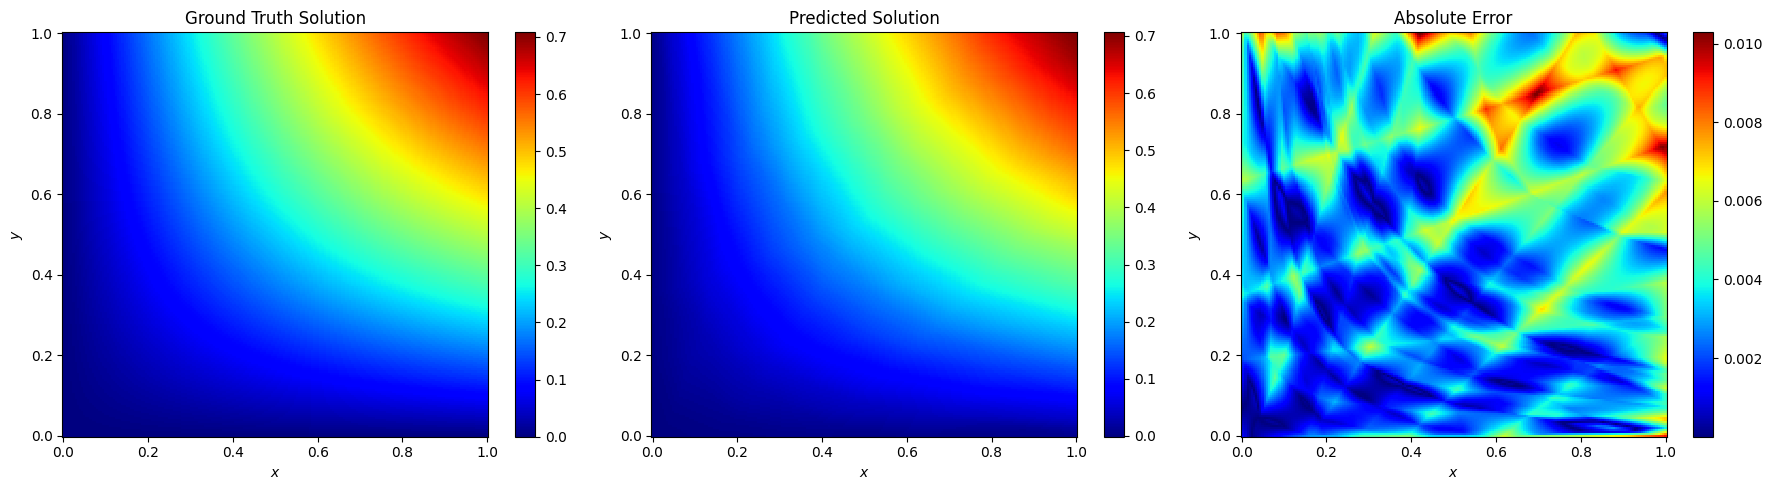

In [16]:
# Input parameters
ub = np.array([1, 1])
lb = np.array([0.0, 0.0])
layers = [2, 40, 40, 40, 40, 1]  # Neural network layers
n, m = 1, 1
k = np.sqrt(np.pi ** 2 * (m ** 2 + n ** 2))
epochs = 1000

# Training data
x_train = torch.linspace(0.0, 1.0, 200, device=device).view(-1, 1).requires_grad_(True)
y_train = torch.linspace(0.0, 1.0, 200, device=device).view(-1, 1).requires_grad_(True)
x_train, y_train = torch.meshgrid(x_train.squeeze(), y_train.squeeze())
x_bc, y_bc = x_train.reshape(-1, 1), y_train.reshape(-1, 1)

# Model initialization
model = PINN(layers, ub=ub, lb=lb).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=200, factor=0.5, verbose=True)

# Train the model
train_pinn(model, optimizer, scheduler, x_bc, y_bc, torch.cat([x_bc, y_bc], dim=1), k, epochs)

# Generate predictions for visualization
model.eval()
with torch.no_grad():
    u_pred = model(torch.cat([x_bc, y_bc], dim=1)).reshape(-1).cpu().numpy()

# Ground truth
X_unique, Y_unique = np.unique(x_bc.detach().cpu().numpy()), np.unique(y_bc.detach().cpu().numpy())
X, Y = np.meshgrid(X_unique, Y_unique)
u_truth = np.sin(n * X) * np.sin(m * Y)

# Visualize the solution
visualize_solution(u_pred, x_bc, y_bc, u_truth)